In [1]:
!pip install einops

In [2]:
import os
import pandas as pd
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from itertools import cycle
import einops
from tqdm.auto import tqdm
import random
from torch.distributions import Categorical

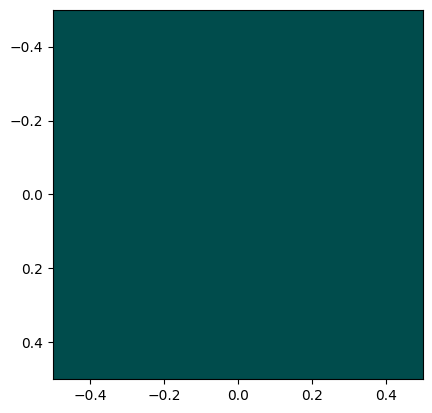

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random pixel values for the image
image_data = np.random.rand(1, 1, 3)  # 100x100 image with 3 color channels (RGB)
image_data[0,0,:] = 0.3
image_data[0,0,0] = 0
# Display the image
plt.imshow(image_data)
plt.show()

In [4]:
import os
import pandas as pd
from torchvision.io import read_image
import numpy as np

class CustomImageDataset(Dataset):
    def __init__(self):
      self.num_images = 1000
      self.images = np.random.rand(self.num_images,1,1,3)

    def __len__(self):
      return len(self.images)

    def __getitem__(self, idx):
      return self.images[idx]

In [5]:
training_dataset = CustomImageDataset()

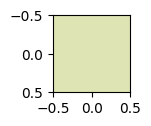

In [6]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(1, 1))
plt.imshow(training_dataset[83])
plt.show()

In [9]:
from torch.utils.data import DataLoader
import torch.nn as nn


train_dataloader = DataLoader(training_dataset, batch_size=128, shuffle=True, drop_last=True)

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=512):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # Add a batch dimension

    def forward(self, x):
        # Add the positional encodings to the input embeddings
        return x + self.encoding[:, :x.size(1)].detach()

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops

class CustomSender(nn.Module):
    def __init__(self, alph_size=10):
        super(CustomSender, self).__init__()
        self.alph_size = alph_size
        # Define your layers or modules here
        self.fc1 = nn.Linear(in_features=3, out_features=16)
        self.positional_encoding = PositionalEncoding(16)
        self.transformer_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=16, nhead=1, batch_first=True, dim_feedforward=32), num_layers=1)
        self.fc3 = nn.Linear(in_features=16, out_features=self.alph_size)


    def forward(self, x, len_message=3):
        # x = [b, 1, 1, 3] -> [b, l, d]
        x = self.fc1(x.flatten(start_dim=1))
        x = einops.repeat(x, 'b d -> b l d', l = len_message)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = self.fc3(x)
        return x

m1 = CustomSender()
x = torch.randn((20, 1,1, 3))
m1(x).shape

torch.Size([20, 3, 10])

In [17]:
class CustomReceiver(nn.Module):
    def __init__(self, alph_size=10):
        super(CustomReceiver, self).__init__()
        self.alph_size = alph_size
        ### Image Side
        self.fc1 = nn.Linear(in_features=3, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=16)
        ### Text Side
        self.emb = nn.Embedding(self.alph_size, 16)
        self.positional_encoding = PositionalEncoding(16, 100)
        self.cls_embedding = nn.Parameter(torch.randn(16))
        self.transformer_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=16, nhead=1, batch_first=True, dim_feedforward=16), num_layers=1)

    def forward_image(self, x):
        # x = [b, 1, 1, 3] -> [b, d]
        x = F.relu(self.fc1(x.flatten(start_dim=1)))
        x = self.fc2(x)
        return x

    def forward_text(self, x, src_key_padding_mask=None):
        # x = [b, l] long Tensor -> [b, d]
        x = self.emb(x)
        batch_size = x.shape[0]
        cls_embedding = einops.repeat(self.cls_embedding, 'd -> b l d', b=batch_size, l=1)
        x = torch.cat((cls_embedding, x), dim=1)
        x = self.positional_encoding(x)
        cls_mask = torch.zeros((batch_size,1))
        words_mask = torch.cat((cls_mask, src_key_padding_mask), dim=1).bool()
        x = self.transformer_encoder(x, src_key_padding_mask=words_mask)
        x = x[:,0,:]
        return x

class SimpleReceiver(nn.Module):
    def __init__(self, alph_size=10):
        super(SimpleReceiver, self).__init__()
        self.alph_size = alph_size
        ### Image Side
        self.fc1 = nn.Linear(in_features=3, out_features=16)
        ### Text Side
        self.emb = nn.Embedding(self.alph_size, 16)


    def forward_image(self, x):
        # x = [b, 1, 1, 3] -> [b, d]
        x = self.fc1(x.flatten(start_dim=1))
        return x

    def forward_text(self, x, src_key_padding_mask=None):
        # x = [b, l] long Tensor -> [b, d]
        x = self.emb(x)
        batch_size = x.shape[0]
        x = x.mean(dim=1)
        return x

In [18]:
def create_mask_after_end_token(input_tensor, end_token_id):
    # Find the index of the [END] token in each row
    end_token_indices = torch.nonzero(input_tensor == end_token_id)

    # Create a mask tensor of the same shape as the input tensor
    mask_tensor = torch.zeros_like(input_tensor)

    # Set elements after the [END] token index in each row to 1
    for batch_idx, end_idx in end_token_indices:
        mask_tensor[batch_idx, end_idx + 1:] = 1

    return mask_tensor

In [19]:
x = torch.randn((20, 1,1, 3))
m1(x)
words = m1(x).argmax(axis=2)
words_mask = create_mask_after_end_token(words, 0)
#m2 = SimpleReceiver()
m2 = CustomReceiver()
m2.forward_text(words, words_mask).shape

torch.Size([20, 16])

In [60]:
m1 = CustomSender(6)
m2 = CustomReceiver(6)
m2_optimizer = torch.optim.Adam(m2.parameters(), lr=1e-3)
m1_optimizer = torch.optim.Adam(m1.parameters(), lr=1e-3)

In [66]:
import time
from torch.distributions import Categorical
import copy

len_message = 3
eaaly_stop_acc = 0.9
max_steps = 2000
log_period_steps = 200
entropy_loss_lambda = 1e-7

data_iterator = iter(train_dataloader)
acc_list = []
loss_list = []
best_acc = 0
best_model_state = None, None
for iter_num in tqdm(range(max_steps)):
  try:
    batch = next(data_iterator)
  except StopIteration:
    data_iterator = iter(train_dataloader)
    batch = next(data_iterator)
    a = batch
  m2_optimizer.zero_grad()
  m1_optimizer.zero_grad()
  ###
  message_logits = m1(batch.float(), len_message)
  message = message_logits.argmax(2) ### [batch, len, alph_size]
  message_mask = create_mask_after_end_token(message, 0)
  m2_img_rprs = m2.forward_image(batch.float())
  m2_mess_rprs = m2.forward_text(message, message_mask)
  rolled_m2_img_rprs = torch.roll(m2_img_rprs, shifts=1, dims=0)
  pos_similarity = F.cosine_similarity(m2_img_rprs, m2_mess_rprs).unsqueeze(1)
  neg_similarity = F.cosine_similarity(rolled_m2_img_rprs, m2_mess_rprs).unsqueeze(1)
  similarity_scores = torch.cat([pos_similarity, neg_similarity], axis=1)
  m2_loss = F.cross_entropy(similarity_scores, torch.LongTensor([0]*similarity_scores.shape[0]))
  m2_loss.backward()
  m2_optimizer.step()
  ###
  log_probs = torch.log(torch.gather(F.softmax(message_logits, dim=2), 2, message.unsqueeze(2)))
  similarity_scores += 0.001 * torch.randn_like(similarity_scores)
  rewards = 1 - similarity_scores.argmax(1).float()
  returns = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
  #####
  temp = (1-message_mask.unsqueeze(2)*log_probs)
  temp2 = (returns.unsqueeze(1) * temp.squeeze(2))
  m1_loss = temp2.sum() / ((1-message_mask).sum())
  #m1_loss = -torch.mean(returns * log_probs)
  ####
  entropy_loss = -Categorical(F.softmax(message_logits, dim=2)).entropy()
  entropy_loss_masked = (((1-message_mask)*entropy_loss)/((1-message_mask).sum())).sum()
  (m1_loss + entropy_loss_lambda*entropy_loss_masked).backward()
  m1_optimizer.step()
  acc = (1 - similarity_scores.argmax(1)).float().mean()
  acc_list.append(acc)
  loss_list.append(m2_loss.item())
  if acc > best_acc:
    print(f"step {iter_num} :", acc.item())
    best_acc = acc
    best_model_state = copy.deepcopy(m1.state_dict()), copy.deepcopy(m2.state_dict())
  if acc.item() > eaaly_stop_acc:
    print(f"step {iter_num} :", acc.item())
    break
  if iter_num % log_period_steps == 0:
    print(f"step {iter_num} :",rewards.mean().item(), m1_loss.item(), entropy_loss_masked.item())

m1.load_state_dict(best_model_state[0])
m2.load_state_dict(best_model_state[1])


  0%|          | 0/2000 [00:00<?, ?it/s]

step 0 : 0.4609375
step 0 : 0.4609375 1.2417634698280722e-09 -1.2872503995895386
step 1 : 0.46875
step 2 : 0.484375
step 3 : 0.546875
step 4 : 0.5703125
step 41 : 0.59375
step 174 : 0.609375
step 200 : 0.515625 2.60770320892334e-08 -1.290758490562439
step 369 : 0.6328125
step 400 : 0.5703125 -9.934107758624577e-09 -1.293737530708313


KeyboardInterrupt: ignored

In [65]:
best_acc

tensor(0.6562)

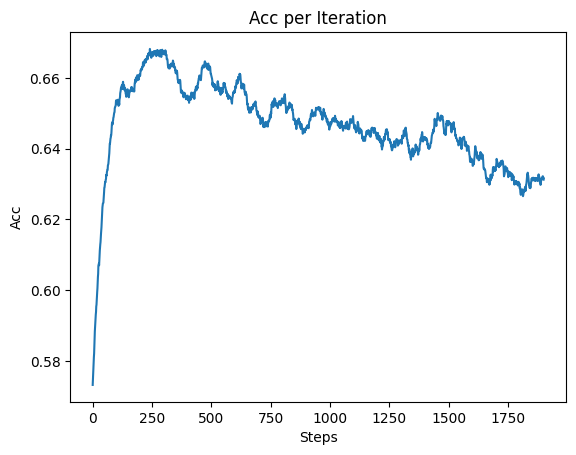

In [63]:
import numpy as np
import matplotlib.pyplot as plt
win_size = 100
smoothed_accuracy = np.convolve(acc_list, np.ones(win_size) / win_size, mode='valid')
plt.plot(smoothed_accuracy)
plt.xlabel('Steps')
plt.ylabel('Acc')
plt.title('Acc per Iteration')
plt.show()

In [57]:
from collections import defaultdict

for batch in train_dataloader:
  message_logits = m1(batch.float(), len_message)
  message = message_logits.argmax(2) ### [batch, len, alph_size]
  message_mask = create_mask_after_end_token(message, 0)
  m2_img_rprs = m2.forward_image(batch.float())
  m2_mess_rprs = m2.forward_text(message, message_mask)
  rolled_m2_img_rprs = torch.roll(m2_img_rprs, shifts=1, dims=0)
  pos_similarity = F.cosine_similarity(m2_img_rprs, m2_mess_rprs).unsqueeze(1)
  neg_similarity = F.cosine_similarity(rolled_m2_img_rprs, m2_mess_rprs).unsqueeze(1)
  similarity_scores = torch.cat([pos_similarity, neg_similarity], axis=1)
  m2_loss = F.cross_entropy(similarity_scores, torch.LongTensor([0]*similarity_scores.shape[0]))
  rewards = 1 - similarity_scores.argmax(1).float()
  print(rewards.mean())

image_dictionary = defaultdict(list)
for i, m in enumerate(message):
  sentence = ""
  for token in m:
    sentence = sentence + str(token.item())
    if sentence[-1] == '0':
      break
  image_dictionary[sentence].append(i)

tensor(0.6250)
tensor(0.6875)
tensor(0.7344)
tensor(0.6875)
tensor(0.7578)
tensor(0.6562)
tensor(0.6953)


In [58]:
image_dictionary = dict(sorted(image_dictionary.items(), key=lambda item: item[0]))

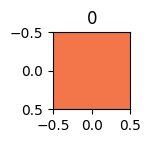

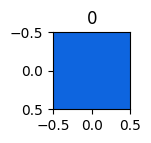

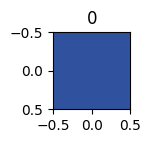

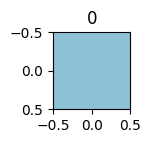

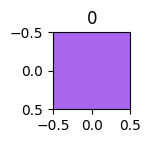

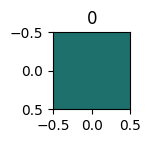

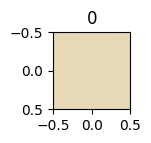

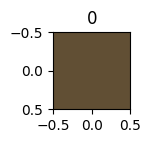

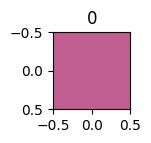

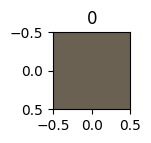

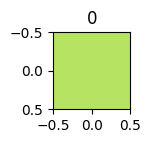

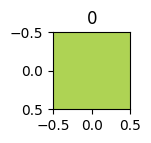

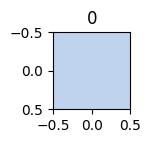

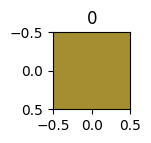

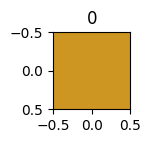

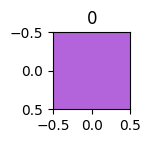

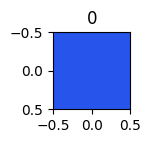

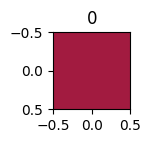

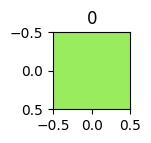

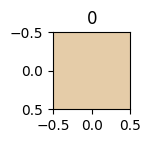

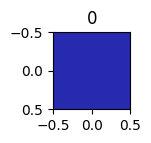

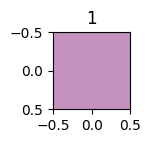

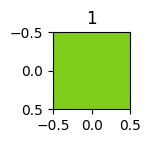

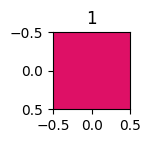

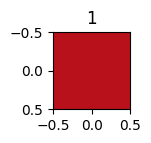

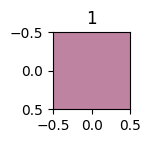

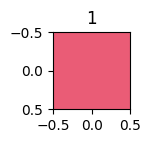

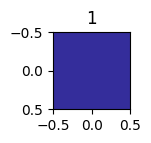

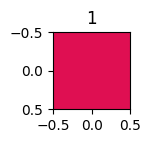

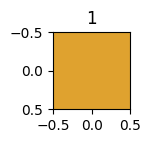

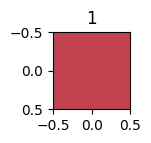

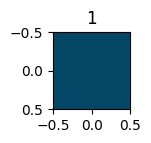

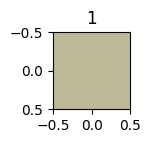

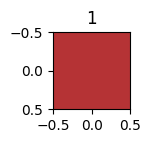

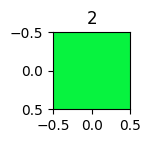

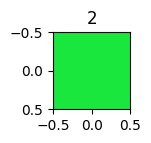

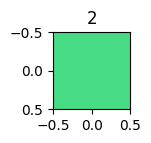

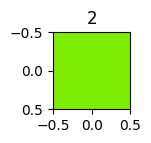

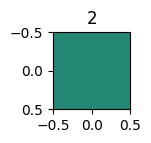

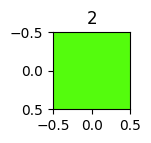

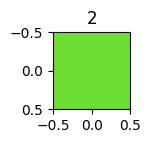

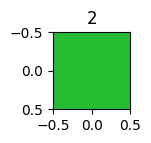

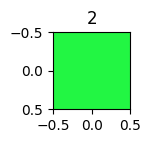

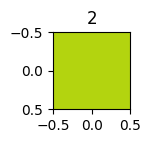

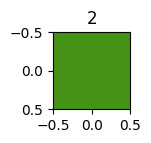

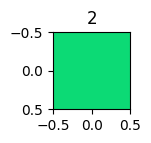

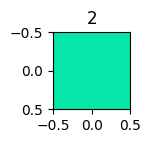

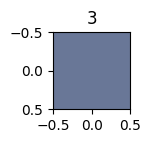

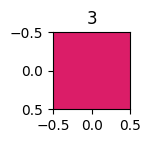

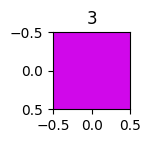

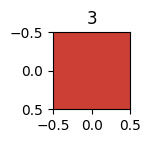

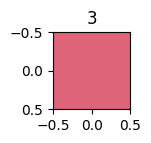

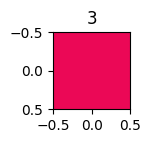

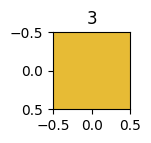

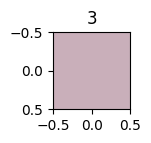

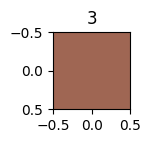

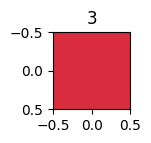

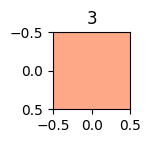

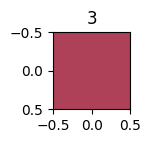

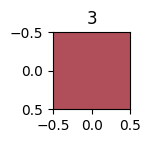

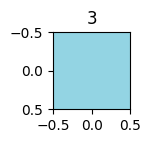

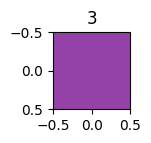

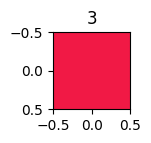

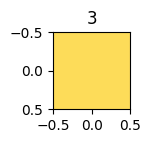

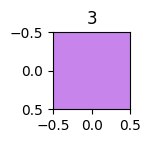

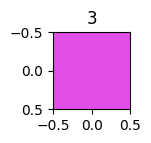

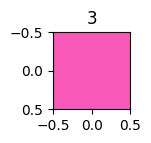

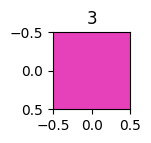

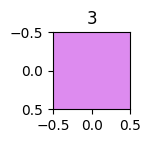

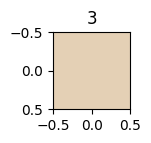

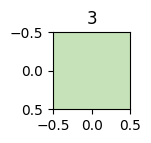

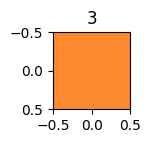

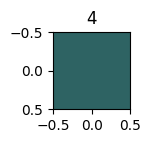

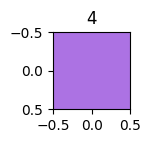

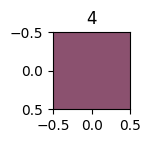

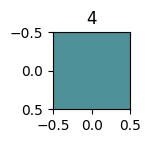

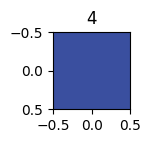

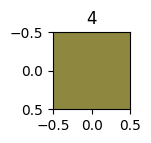

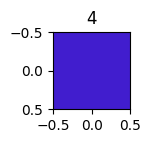

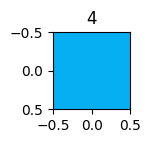

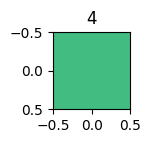

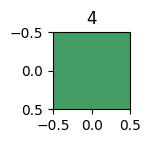

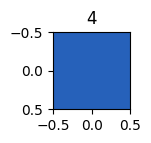

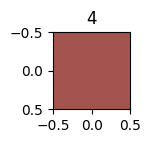

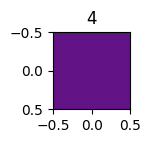

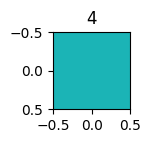

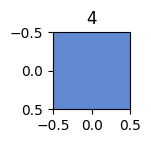

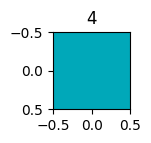

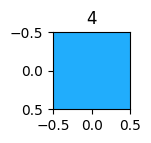

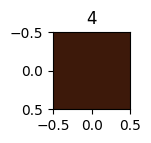

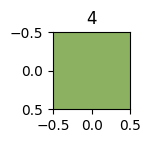

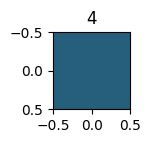

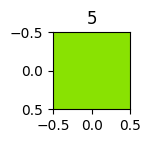

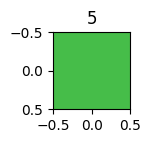

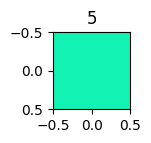

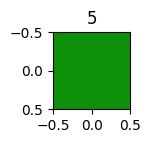

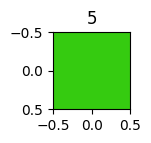

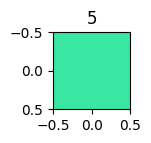

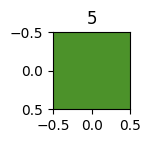

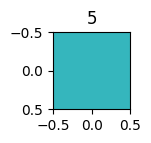

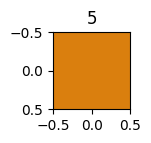

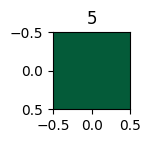

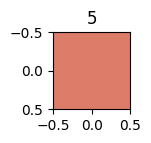

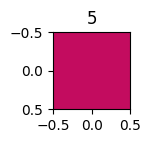

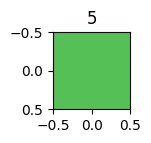

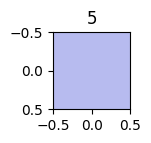

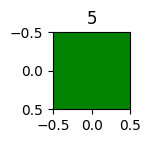

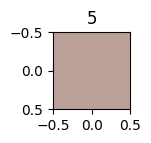

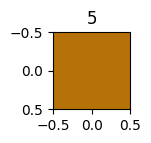

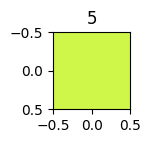

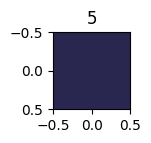

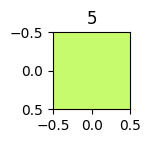

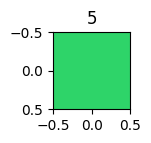

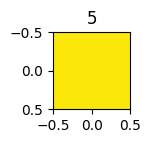

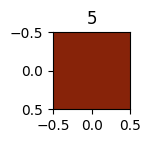

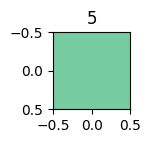

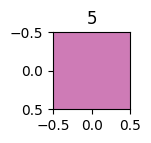

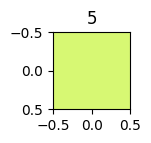

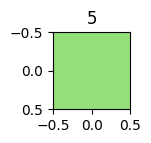

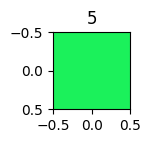

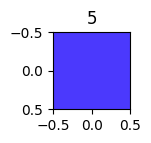

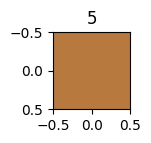

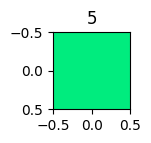

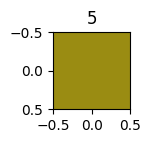

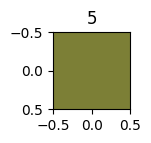

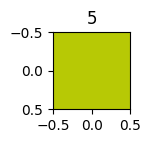

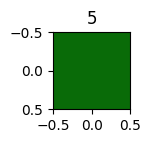

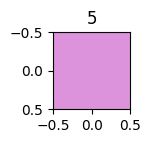

In [59]:
for sentence, image_indices in image_dictionary.items():
  for image_idx in image_indices:
    fig = plt.figure(figsize=(1, 1))
    plt.imshow(batch[image_idx])
    plt.title(f"{sentence}")
    plt.show()